# A deep learning-based dual latent space method for the estimation of physical flow properties from fiber-optic measurements

### Misael M. Morales, Michael Pyrcz, Carlos Torres-Verdin
***

In [1]:
from utils import *

2024-04-14 16:30:43.344286: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-14 16:30:43.344338: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-14 16:30:43.345008: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-14 16:30:43.349052: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-14 16:30:44.025760: W tensorflow/compiler/tf2

In [16]:
y_data = np.load('flow_params.npz')
flow_rates, sparse_flow_rates = y_data['flow_rates'], y_data['sparse_flow_rates']
inj_idx,    data_labels       = y_data['inj_idx'],    y_data['labels']

print('Flow Rates: {}'.format(flow_rates.shape))
print('Sparse Flow Rates: {}'.format(sparse_flow_rates.shape))
print('Injection Index: {}'.format(inj_idx))
print('Data Labels: {}'.format(data_labels))

Flow Rates: (6, 5, 4)
Sparse Flow Rates: (6, 96, 4)
Injection Index: [15 26 38 42 52]
Data Labels: ['Oil' 'Gas' 'Water' 'Sand']


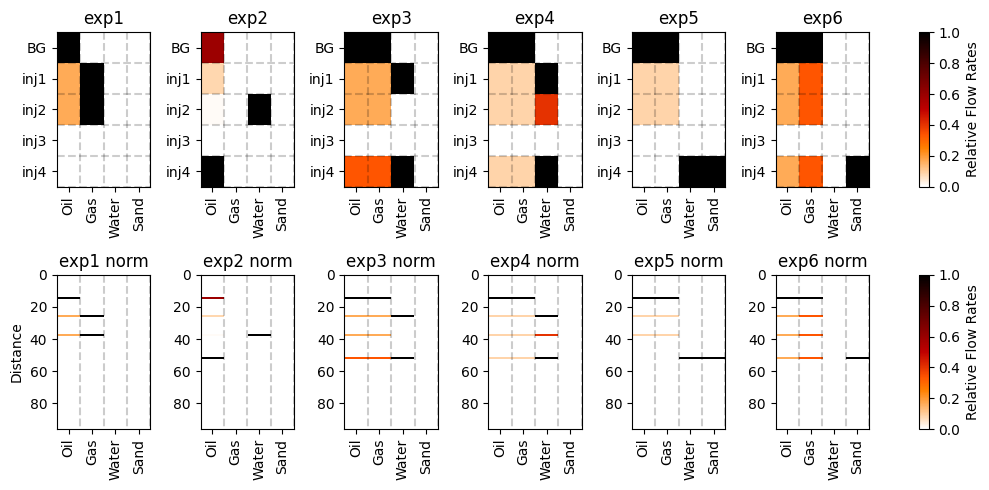

In [18]:
fig, axs = plt.subplots(2, 7, figsize=(10,5), width_ratios=[1]*6+[0.1])
ymax = sparse_flow_rates.shape[1]
for j in range(6):
    axs[0,j].set_title(f'exp{j+1}')
    axs[1,j].set_title(f'exp{j+1} norm')
    for i in range(2):
        axs[i,j].set_xticks(range(len(data_labels)))
        axs[i,j].set_xticklabels(data_labels, rotation=90)
        axs[i,j].vlines([np.arange(4)+0.5], [0 if i==1 else -0.5], [ymax if i==1 else 5], color='k', ls='--', alpha=0.2)
        axs[0,j].set_yticks(range(5))
        axs[0,j].set_yticklabels(['BG','inj1', 'inj2', 'inj3', 'inj4'])
        axs[0,j].set(xlim=(-0.5,3.5), ylim=(4.5,-0.5))
        axs[0,j].hlines([np.arange(5)+0.5], -0.5, 3.5, color='k', ls='--', alpha=0.1)
        axs[1,j].set(xlim=(-0.5,3.5), ylim=(ymax,0), ylabel='Distance' if j==0 else None)
    im0 = axs[0,j].imshow(flow_rates[j], cmap='gist_heat_r', aspect='auto')
    im1 = axs[1,j].imshow(sparse_flow_rates[j], cmap='gist_heat_r', aspect='auto', interpolation='none')
cb0 = plt.colorbar(im0, cax=axs[0,6], pad=0.04, fraction=0.046); cb0.set_label('Relative Flow Rates')
cb1 = plt.colorbar(im1, cax=axs[1,6], pad=0.04, fraction=0.046); cb1.set_label('Relative Flow Rates')
plt.tight_layout()
plt.show()

In [21]:
X_data = np.load('das_dts.npz')
print(X_data.keys())

KeysView(NpzFile 'das_dts.npz' with keys: exp1, exp2, exp3, exp4, exp5...)


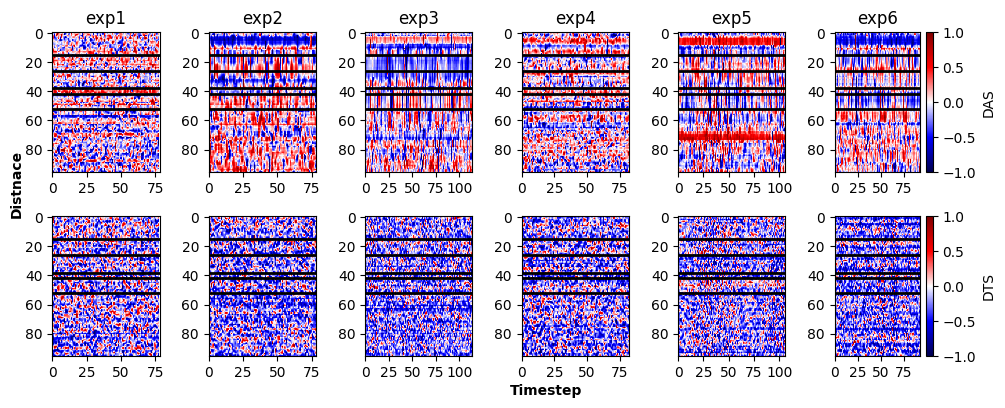

In [23]:
fig, axs = plt.subplots(2, 6, figsize=(10,4))
for j in range(6):
    exp = X_data['exp{}'.format(j+1)]
    xmax = exp.shape[0]
    for i in range(2):
        im = axs[i,j].imshow(exp[...,i].squeeze().T, cmap='seismic', aspect='auto')
        axs[i,j].hlines(inj_idx, 0, xmax, color='k', lw=2)
        axs[i,j].set(xlim=(0,xmax), xticks=np.arange(0,xmax,25))
    axs[0,j].set(title='exp{}'.format(j+1))
cb1 = plt.colorbar(im, ax=axs[0,5], label='DAS')
cb2 = plt.colorbar(im, ax=axs[1,5], label='DTS')
fig.text(0.5, 0, 'Timestep', weight='bold')
fig.text(0, 0.45, 'Distnace', weight='bold', rotation=90)
plt.tight_layout()
plt.show()

In [45]:
das1 = np.expand_dims(X_data['exp1'][...,0],-1)
das2 = np.expand_dims(X_data['exp2'][...,0],-1)
das3 = np.expand_dims(X_data['exp3'][...,0],-1)
das4 = np.expand_dims(X_data['exp4'][...,0],-1)
das5 = np.expand_dims(X_data['exp5'][...,0],-1)
das6 = np.expand_dims(X_data['exp6'][...,0],-1)
all_das = [das1, das2, das3, das4, das5, das6]

dts1 = np.expand_dims(X_data['exp1'][...,1],-1)
dts2 = np.expand_dims(X_data['exp2'][...,1],-1)
dts3 = np.expand_dims(X_data['exp3'][...,1],-1)
dts4 = np.expand_dims(X_data['exp4'][...,1],-1)
dts5 = np.expand_dims(X_data['exp5'][...,1],-1)
dts6 = np.expand_dims(X_data['exp6'][...,1],-1)
all_dts = [dts1, dts2, dts3, dts4, dts5, dts6]

flow1 = sparse_flow_rates[0]
flow2 = sparse_flow_rates[1]
flow3 = sparse_flow_rates[2]
flow4 = sparse_flow_rates[3]
flow5 = sparse_flow_rates[4]
flow6 = sparse_flow_rates[5]
all_flow = [flow1, flow2, flow3, flow4, flow5, flow6]

for i, (a,t,f) in enumerate(zip(all_das, all_dts, all_flow)):
    print('Experiment {} - DAS: {}  | DTS: {}   | Flow: {}'.format(i+1, a.shape, t.shape, f.shape))

Experiment 1 - DAS: (78, 96, 1)  | DTS: (78, 96, 1)   | Flow: (96, 4)
Experiment 2 - DAS: (78, 96, 1)  | DTS: (78, 96, 1)   | Flow: (96, 4)
Experiment 3 - DAS: (114, 96, 1)  | DTS: (114, 96, 1)   | Flow: (96, 4)
Experiment 4 - DAS: (82, 96, 1)  | DTS: (82, 96, 1)   | Flow: (96, 4)
Experiment 5 - DAS: (106, 96, 1)  | DTS: (106, 96, 1)   | Flow: (96, 4)
Experiment 6 - DAS: (93, 96, 1)  | DTS: (93, 96, 1)   | Flow: (96, 4)


AutoEncoder # of parameters: 45,333
    Encoder # of parameters: 25,220


2024-04-14 16:43:28.002567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type CPU is enabled.
2024-04-14 16:43:34.176850: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-04-14 16:43:34.389426: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: Permission denied
2024-04-14 16:43:34.778608: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: Permission denied
2024-04-14 16:43:37.708009: I external/local_xla/xla/service/service.cc:168] XLA service 0x7ff159cdae50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-14 16:43:37.708050: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-04-14 16:43:37.724214: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disab

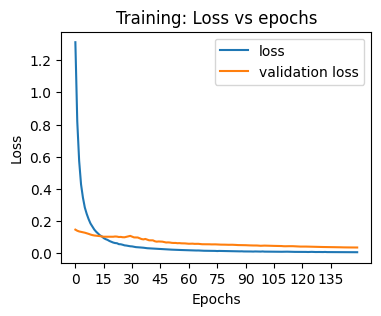

In [38]:
das_m2m, das_m2z = das_Unet(xsteps=96)
print('AutoEncoder # of parameters: {:,}'.format(das_m2m.count_params()))
print('    Encoder # of parameters: {:,}'.format(das_m2z.count_params()))

das_m2m.compile(optimizer=Nadam(1e-3), loss='mse', metrics=['mse'])
fit_das = das_m2m.fit(das1, das1,
                        shuffle          = True,
                        epochs           = 150,
                        batch_size       = 10,
                        validation_split = 0.2,
                        verbose          = 0)
plot_loss(fit_das, figsize=(4,3))

3/3 [==============================] - 0s 5ms/step
SSIM = 65.77
MSE  = 1.168e-02
PSNR = 25.35


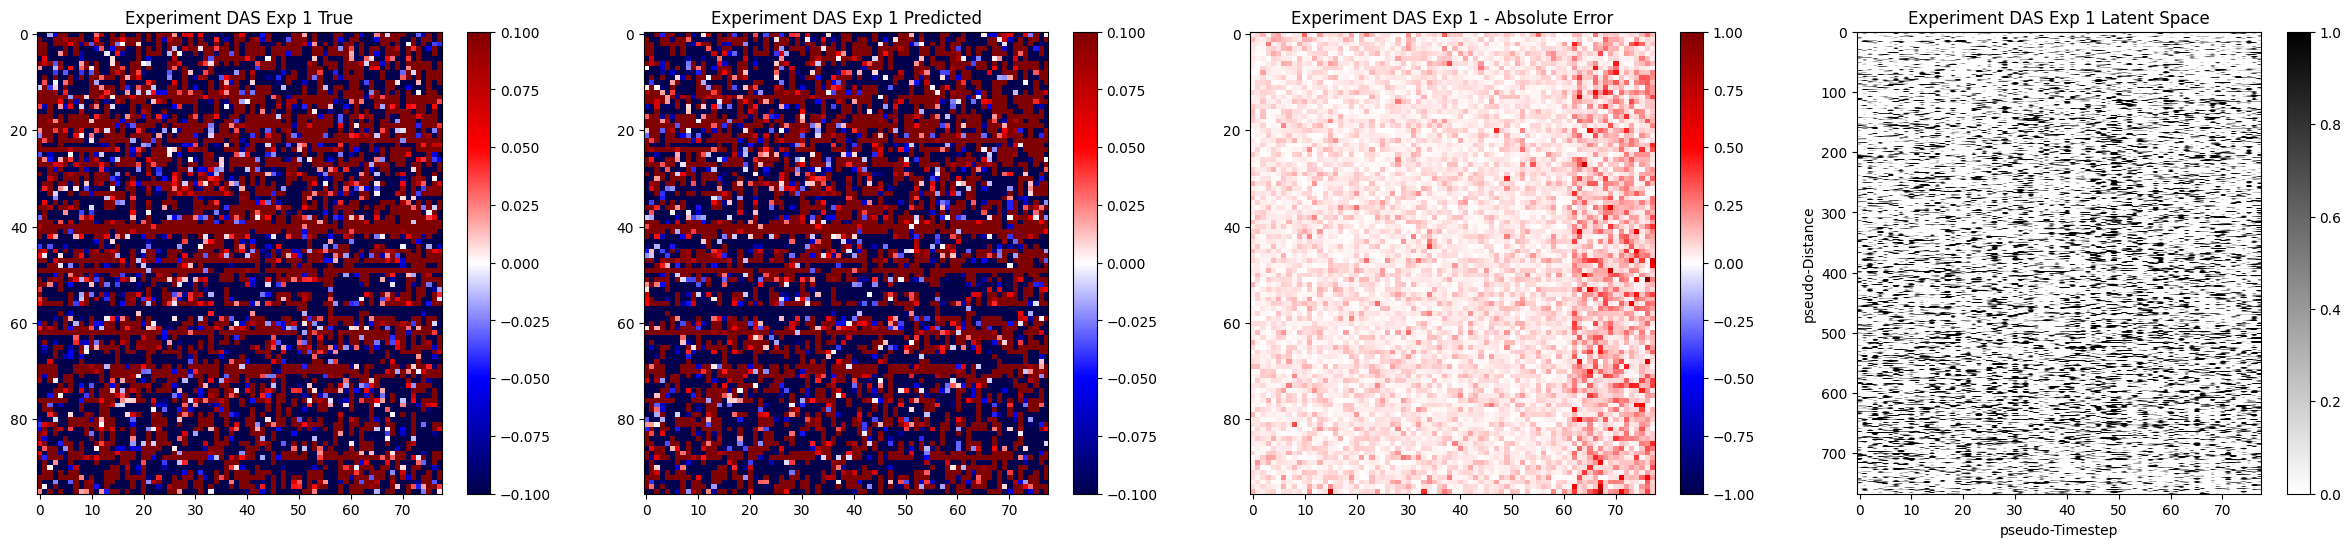

In [39]:
das1_pred = das_m2m.predict(das1).squeeze().astype('float64')
das1_z = das_m2z.predict(das1).squeeze().astype('float64')
print('SSIM = {:.2f}'.format(100*image_ssim(das1.squeeze().T, das1_pred.T, data_range=1.0)))
print('MSE  = {:.3e}'.format(image_mse(das1.squeeze().T, das1_pred.T)))
print('PSNR = {:.2f}'.format(image_psnr(das1.squeeze().T, das1_pred.T, data_range=2)))

plot_true_pred_z(das1, das1_pred, das1_z, filenum='DAS Exp 1')

AutoEncoder # of parameters: 45,333
    Encoder # of parameters: 25,220


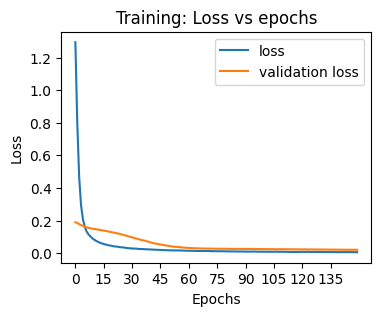

In [40]:
dts_m2m, dts_m2z = dts_Unet(xsteps=96)
print('AutoEncoder # of parameters: {:,}'.format(dts_m2m.count_params()))
print('    Encoder # of parameters: {:,}'.format(dts_m2z.count_params()))

dts_m2m.compile(optimizer=Nadam(1e-3), loss='mse', metrics=['mse'])
fit_dts = dts_m2m.fit(dts1, dts1,
                        shuffle          = True,
                        epochs           = 150,
                        batch_size       = 10,
                        validation_split = 0.2,
                        verbose          = 0)
plot_loss(fit_dts, figsize=(4,3))

3/3 [==============================] - 0s 5ms/step
SSIM = 91.40
MSE  = 8.184e-03
PSNR = 26.89


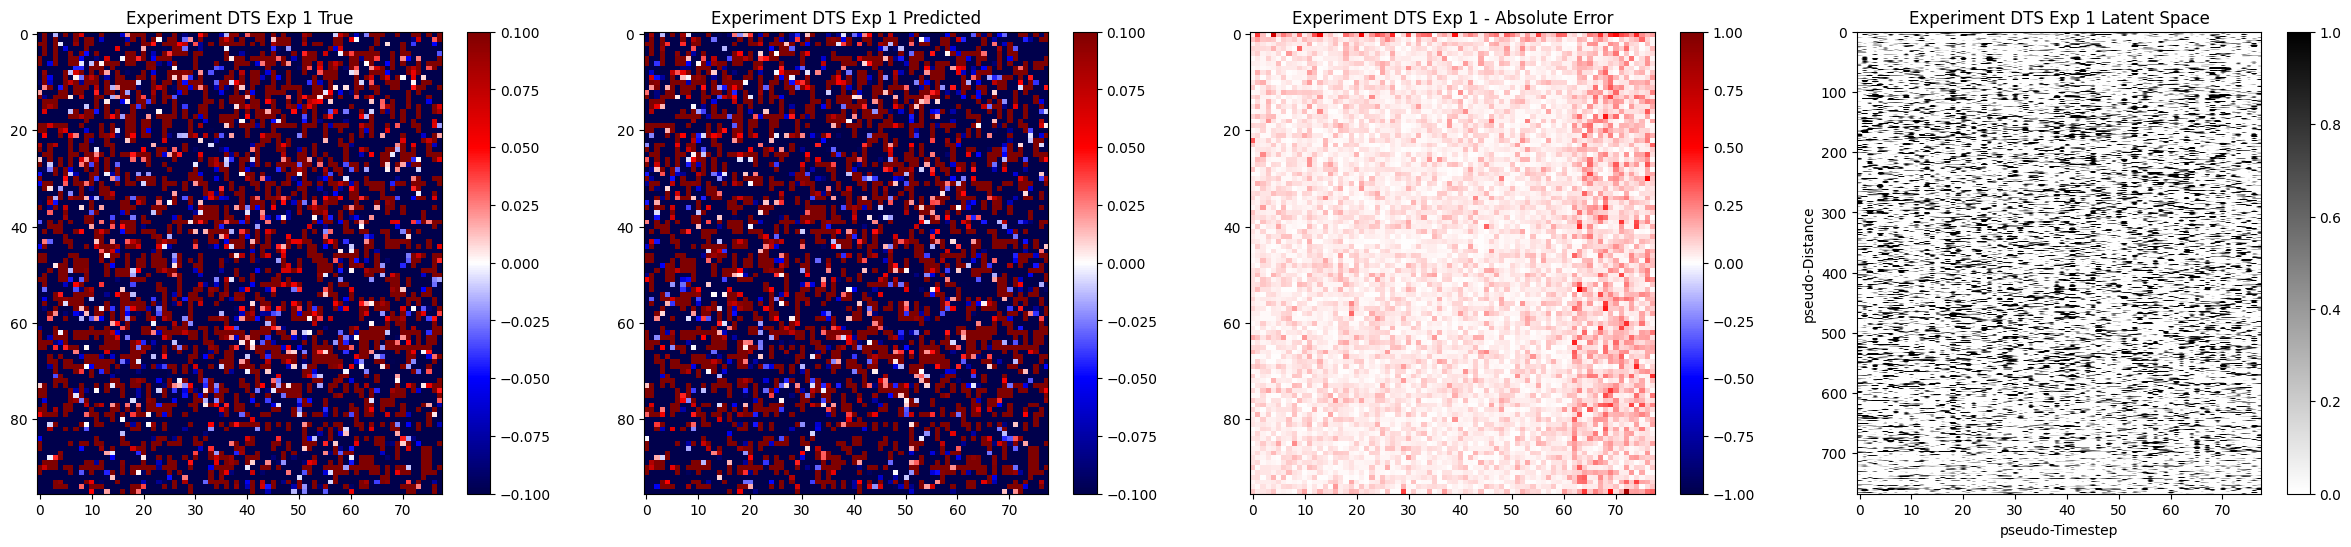

In [41]:
dts1_pred = dts_m2m.predict(dts1).squeeze().astype('float64')
dts1_z = dts_m2z.predict(dts1).squeeze().astype('float64')
print('SSIM = {:.2f}'.format(100*image_ssim(dts1.squeeze().T, dts1_pred.T, data_range=1.0)))
print('MSE  = {:.3e}'.format(image_mse(dts1.squeeze().T, dts1_pred.T)))
print('PSNR = {:.2f}'.format(image_psnr(dts1.squeeze().T, dts1_pred.T, data_range=2)))

plot_true_pred_z(dts1, dts1_pred, dts1_z, filenum='DTS Exp 1')

MSE:  7.37e-09
SSIM: 1.000


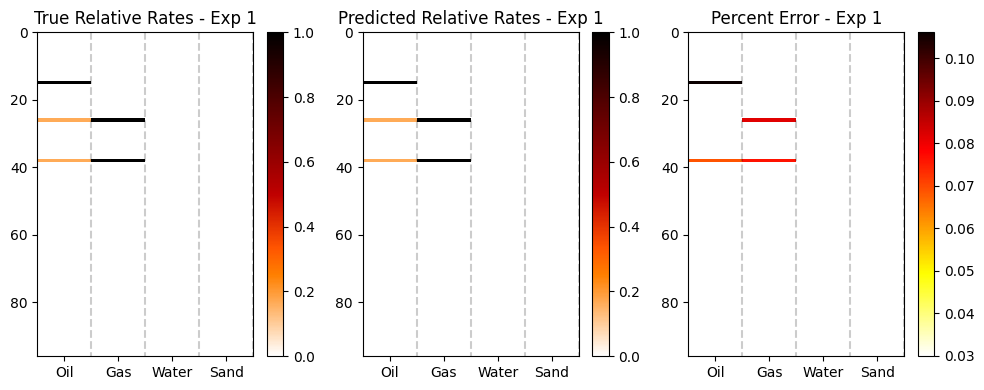

Shapes - z_DAS: (114, 12, 64) | z_DTS: (114, 12, 64)
MSE:  1.18e-08
SSIM: 1.000


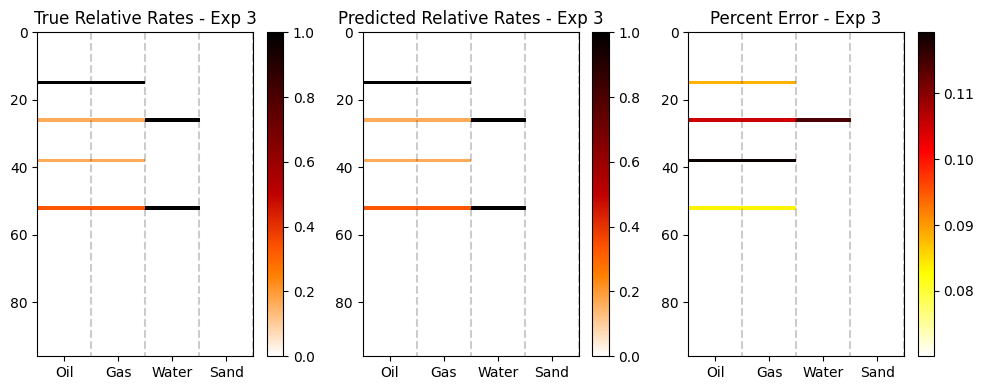

In [142]:
reg = make_flowpred_from_dual_latent(das1_z, dts1_z, flow1, xsteps=96, expnum='1', method=Ridge())
transfer_learning_predictions_dual(das3, dts3, flow3, das_m2z, dts_m2z, expnum='3', xsteps=96, method=Ridge())

***
## Single Latent Space

In [154]:
flow_dict = {'1':flow1, '2':flow2, '3':flow3, '4':flow4, '5':flow5, '6':flow6}

models = {'das': {'m2m':das_m2m, 'm2z':das_m2z}, 'dts': {'m2m':dts_m2m, 'm2z':dts_m2z}}

all_data = {'das': {'1':das1, '2':das2, '3':das3, '4':das4, '5':das5, '6':das6}, 
            'dts': {'1':dts1, '2':dts2, '3':dts3, '4':dts4, '5':dts5, '6':dts6}}

single_latents = make_single_latents(models, all_data)

DAS Latent Spaces: 
---------------------------------------------------------
45: (78, 12, 64) | 48: (78, 12, 64)   | 54: (114, 12, 64)
64: (82, 12, 64) | 109: (106, 12, 64) | 128: (93, 12, 64)
---------------------------------------------------------



DTS Latent Spaces: 
---------------------------------------------------------
45: (78, 12, 64) | 48: (78, 12, 64)   | 54: (114, 12, 64)
64: (82, 12, 64) | 109: (106, 12, 64) | 128: (93, 12, 64)
---------------------------------------------------------


In [155]:
single_latents['das']

{'45': array([[[ 8.01020145e-01, -8.73086572e-01, -1.12683132e-01, ...,
           4.00893301e-01, -7.40688562e-01,  7.27822363e-01],
         [ 1.04588354e+00, -6.39202595e-01,  1.16435170e-01, ...,
          -1.07337570e+00, -6.25199437e-01,  7.80167520e-01],
         [-8.05934668e-01, -6.11310303e-02, -3.85039806e-01, ...,
           4.58442360e-01, -6.97012186e-01, -6.23231053e-01],
         ...,
         [ 7.79767990e-01,  4.84730393e-01, -1.55384392e-01, ...,
           1.99797124e-01, -1.75543725e+00, -1.21398401e+00],
         [-4.29399967e-01, -5.88127077e-01,  1.68281674e+00, ...,
           2.98567027e-01,  2.19621801e+00,  9.16388452e-01],
         [ 6.86188340e-01,  1.19827569e+00, -7.49314785e-01, ...,
          -1.05122137e+00, -5.59001565e-01, -7.18867183e-02]],
 
        [[-5.03350973e-01, -6.13654613e-01,  1.36252046e+00, ...,
          -7.10479140e-01, -4.69276905e-01,  9.68053877e-01],
         [-5.54972351e-01, -1.25975108e+00,  1.71821523e+00, ...,
          -1.63

In [151]:
make_flowpred_from_single_latent(single_latents, flow_dict, expnum='2', xsteps=96, method=Ridge())

KeyError: '2'

***
# END